In [2]:
%matplotlib inline

Dataset과 DataLoader
==========================================================================


입력 데이터를 처리하는 코드는 지저분하고 유지보수가 어려울 수 있다;
더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋을 다루는 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.
PyTorch는 ``torch.utils.data.DataLoader``와 ``torch.utils.data.Dataset``의  데이터를 다루기 위한 두 가지 기본 요소를 
제공하여 PyTorch 자체가 제공해주는 미리 준비해된(pre-loaded) 데이터셋 뿐만 아니라 사용자가 가지고 있는 데이터를 사용할 수 있도록 한다.

**``Dataset``은 데이터와 정답(label)을 저장하고, ``DataLoader``는 ``Dataset``을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다**.

PyTorch의 도메인 특화 라이브러리들은 FashionMNIST와 같은 다양한 미리 준비해둔(pre-loaded) 데이터셋을 제공한다.
데이터셋은 ``torch.utils.data.Dataset``의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있다.
이러한 데이터셋은 모델을 만들어보고(prototyping), 성능을 측정(benchmark)하는데 사용할 수 있다.
아래의 링크에서 PyTorch가 제공하는 다양한 미리 준비된 데이터셋들을 찾아볼 수 있다:

* [이미지 데이터셋](<https://pytorch.org/vision/stable/datasets.html>)
* [텍스트 데이터셋](<https://pytorch.org/text/stable/datasets.html>)
* [오디오 데이터셋](<https://pytorch.org/audio/stable/datasets.html>)




데이터셋 불러오기
------------------------------------------------------------------------------------------

`TorchVision` 에서 [`Fashion-MNIST`](<https://research.zalando.com/project/fashion_mnist/fashion_mnist/>) 데이터셋을
불러오는 예제를 살펴보자. Fashion-MNIST는 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있다.
각 예제는 흑백(grayscale)의 28x28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성된다.

다음 매개변수들을 사용하여 [`FashionMNIST 데이터셋`](<https://pytorch.org/vision/stable/datasets.html#fashion-mnist>)을 불러온다:
 - ``root``는 학습/테스트 데이터가 저장되는 경로이다.
 - ``train``은 학습용 또는 테스트용 데이터셋 여부를 지정한다.
 - ``download=True``는 ``root``에 데이터가 없는 경우 인터넷에서 다운로드한다.
 - ``transform``과 ``target_transform``은 특징(feature)과 정답(label)의 변형(transform)을 지정한다.



In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



데이터셋을 순회하고 시각화하기
------------------------------------------------------------------------------------------

``Dataset``에 리스트(list)처럼 직접 접근(index)할 수 있다. 
``matplotlib``을 사용하여 학습 데이터의 일부를 시각화해보자.



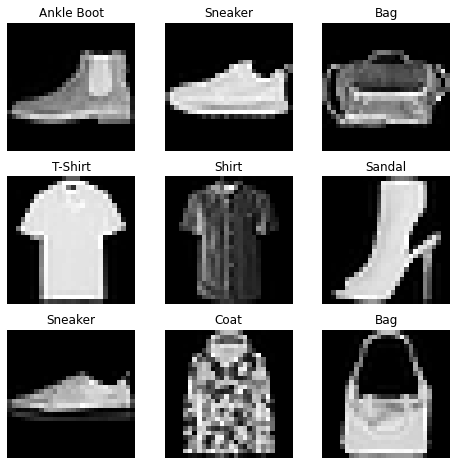

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  # squeeze()는 shape이 (1,28,28) 텐서를 (28, 28)인 텐서로 변환
plt.show()

------------------------------------------------------------------------------------------




파일에서 사용자 정의 데이터셋 만들기
------------------------------------------------------------------------------------------

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다: `__init__`, `__len__`, and `__getitem__`.
아래의 클래스 `CustomImageDataset`에서는 FashionMNIST 이미지들이 ``img_dir`` 디렉토리에 저장되어 있고, 정답은 별개의 csv 파일인 ``annotations_file``에 저장되어 있다고 가정한다.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

**Note**: 사용자 정의 데이터셋을 만들기 위해서 반드시 이렇게 클래스를 정의해야 하는 것은 아니다. 이것은 가능한 몇 가지 방법 중 하나이다.

### __init__

`__init__` 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행된다.
여기서는 이미지와 주석 파일(`annotation_file`)이 포함된 디렉토리와 두가지 변형(transform)을 초기화한다.

주석 파일인 `labels.csv` 파일에는 다음과 같은 형식으로 이미지 파일명과 라벨(label)이 저장되어 있다고 가정한다:

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__

`__len__` 함수는 데이터셋의 샘플 개수를 반환한다.

In [ ]:
def __len__(self):
    return len(self.img_labels)

### __getitem__


__getitem__ 함수는 주어진 인덱스 ``idx`` 에 해당하는 샘플을 데이터셋에서 불러오고 반환한다.
디스크에서 이미지의 경로를 생성하고 ``read_image``를 사용하여 이미지를 로드하여 텐서로 변환하고, ``self.img_labels``의 csv 데이터로부터
해당하는 정답(label)을 가져오고, 필요한 경우 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 반환한다.

In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

------------------------------------------------------------------------------------------




DataLoader로 학습용 데이터 준비하기
------------------------------------------------------------------------------------------

일반적으로 모델을 학습할 때 데이터들은 "미니배치(minibatch)"의 형태로 사용하고, 매 에폭(epoch)마다 데이터를 다시 섞어서(shuffle) 과적합(overfit)을 막으며, 또한 
Python의 ``multiprocessing``을 사용하여 데이터 처리 속도를 높인다.

``DataLoader``는 간단한 API로 이러한 입력 파이프라인의 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)이다.



In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

DataLoader를 통해 순회하기(iterate)
------------------------------------------------------------------------------------------

``DataLoader``에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다.
아래의 각 순회(iteration)는 (각각 ``batch_size=64``의 특징(feature)과 정답(label)을 포함하는) ``train_features``와 ``train_labels``의 묶음(batch)을 반환한다. ``shuffle=True``로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞인다.
(데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 [Samplers](<https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>)
를 살펴보라.)



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


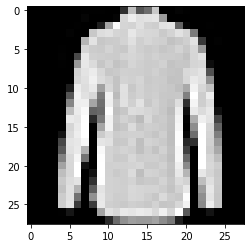

Label: 6


In [6]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

------------------------------------------------------------------------------------------


